In [1]:
import numpy as np
import cv2
from scipy import stats
from scipy.ndimage import gaussian_gradient_magnitude


import matplotlib.pyplot as plt
from skimage import data, color, filters
from skimage.transform import resize
from skimage.io import imread
from LieGroupsFlow import so2,to_lie_alg_manifold,forword_euler_mathod_lie_alg,lie_alg_manifold_to_orientations, angles_dist

In [19]:
def gradient_to_angles(dx,dy):
    ''' Note: output of np.arctan2 is in [-pi,pi]'''
    return np.arctan2(dy, dx) # + np.pi / 2

def angles_to_gradient(angles):
    '''returd: the gradient in the perpendicular direction'''
    dx = np.cos(angles)# - np.pi/2)
    dy = np.sin(angles)#- np.pi/2)
    return dx,dy

def add_noise(dx,dy):
    angles =  gradient_to_angles(dx,dy)
    
    mean = 0
    std_deviation=1
    shape = angles.shape
    low = -np.pi
    high = np.pi

    gaussian_noise = stats.truncnorm.rvs(low, high, mean,std_deviation, shape)
    ndx ,ndy = angles_to_gradient(angles+gaussian_noise)
    return ndx,ndy

def add_noise_a(angles,mean=0,std=1):    
    shape = angles.shape
    low = -np.pi
    high = np.pi

    gaussian_noise = stats.truncnorm.rvs(low, high, mean,std, shape)
    return angles+gaussian_noise
    

def compute_gradients(image):
    # Compute the gradient in the x direction
    grad_x = filters.sobel_h(image)
    # Compute the gradient in the y direction
    grad_y = filters.sobel_v(image)
    
    # Normalize the gradients for better visibility
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    grad_x_normalized = grad_x / (magnitude + 1e-8)  # Avoid division by zero
    grad_y_normalized = grad_y / (magnitude + 1e-8)
    
    return grad_x_normalized, grad_y_normalized

def plot_sparse_quiver(image, grad_x, grad_y, step=10):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray', interpolation='none',alpha=0.2)
    
    
    # Reduce the number of arrows by using slicing
    plt.quiver(np.arange(0, grad_x.shape[1], step),
               np.arange(0, grad_y.shape[0], step),
               grad_x[::step, ::step],
               grad_y[::step, ::step],
               color='tomato', scale=40, pivot='middle', alpha=0.6)
    
    plt.title('Sparse Edge Flow (Quiver Plot)')
    plt.axis('off')
    plt.show()
    
def plot_two_sparse_quiver(image, grad_x, grad_y, grad_x1=None, grad_y1=None,step=3):
    '''Here the input grad is alredy sparse'''
    
    plt.figure(figsize=(10, 10))
    plt.imshow(image, interpolation='none',alpha=0.5)
    
    # Reduce the number of arrows by using slicing
    plt.quiver(np.arange(0, image.shape[1], step),
               np.arange(0, image.shape[0], step),
               grad_x,
               grad_y,
               color='tomato', scale=40, pivot='middle', alpha=1)
    
    # Reduce the number of arrows by using slicing
    if grad_x1 is not None:
        plt.quiver(np.arange(0, image.shape[1], step),
                   np.arange(0, image.shape[0], step),
                   grad_x1,
                   grad_y1,
                   color='b', scale=40, pivot='middle', alpha=1)
    
    plt.title('Sparse Edge Flow (Quiver Plot)')
    plt.axis('off')
    plt.show()

In [36]:
def load_gussians():
    # Create a grid of points
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)

    # Create a Gaussian function for the image
    def gaussian(x, y, amplitude, x0, y0, sigma_x, sigma_y):
        return amplitude * np.exp(-(((x - x0) ** 2) / (2 * sigma_x ** 2) + ((y - y0) ** 2) / (2 * sigma_y ** 2)))

    # Create a synthetic image with multiple Gaussians
    image = (gaussian(X, Y, 1, -5, 0, 1, 2) + 
             gaussian(X, Y, 1, 5, 0, 1, 2) + 
             gaussian(X, Y, 2, 0, 5, 2, 1))

    return image

# Main execution
img = load_gussians()
grad_x, grad_y = compute_gradients(img)

In [37]:
step = 3
dx, dy= grad_x[::step,::step], grad_y[::step,::step]
sparse_angles = gradient_to_angles(dx, dy)

In [38]:
import matplotlib
matplotlib.use('TkAgg')

ImportError: Cannot load backend 'TkAgg' which requires the 'tk' interactive framework, as 'headless' is currently running

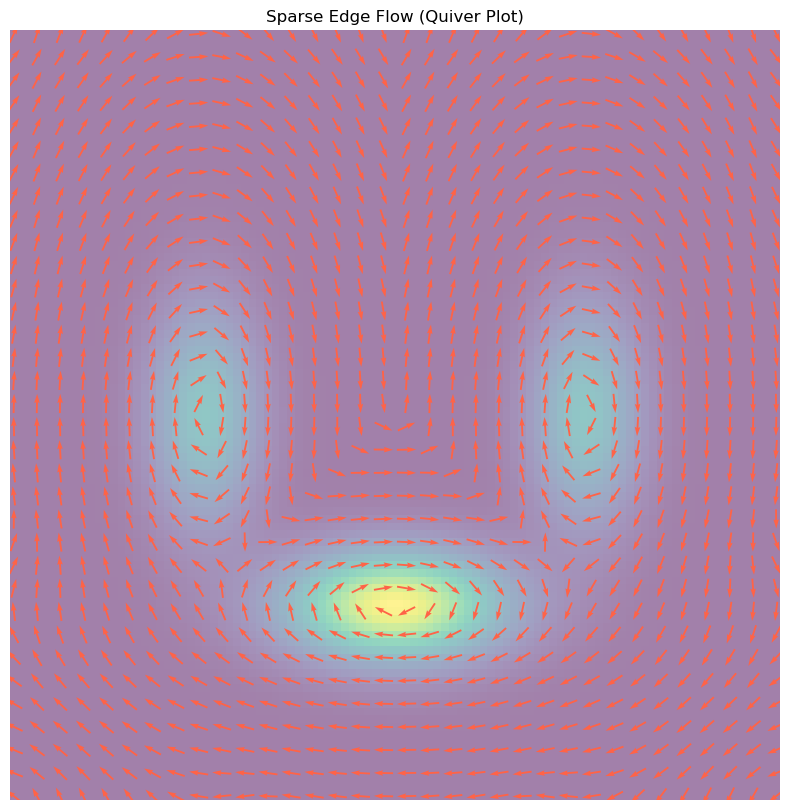

In [39]:
dx,dy = angles_to_gradient(sparse_angles)
plot_two_sparse_quiver(img,dx,dy,step=step)

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 66.58it/s]


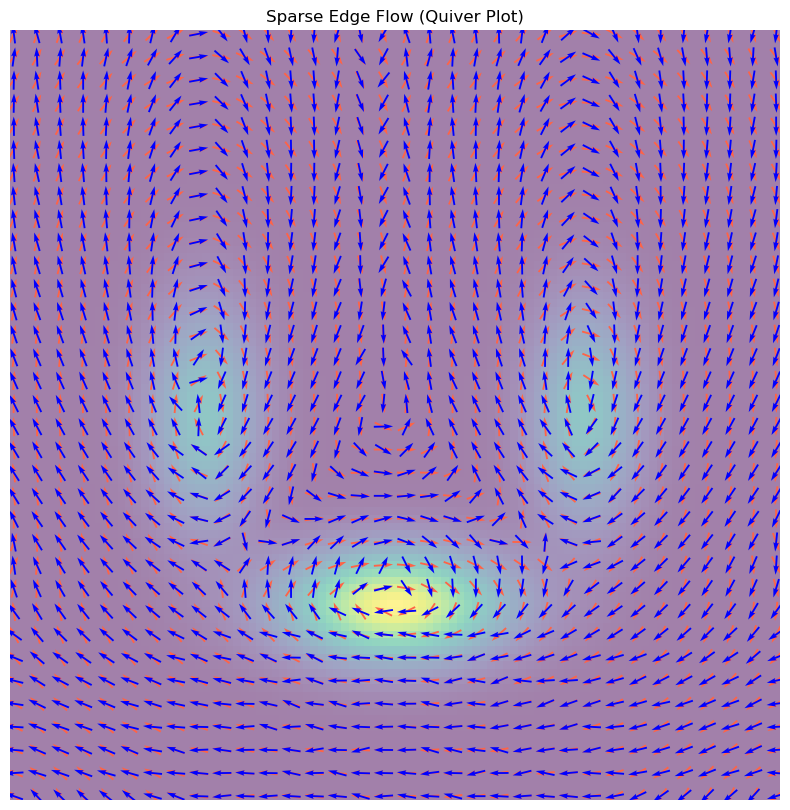

In [40]:
lie_group_manifold = so2(sparse_angles)

# Lie algebra so(2) manifold
lie_alg_manifold = to_lie_alg_manifold(lie_group_manifold)

new_lie_alg_manifold = forword_euler_mathod_lie_alg(lie_alg_manifold,100,dt=0.01)
new_thetas = lie_alg_manifold_to_orientations(new_lie_alg_manifold)

new_flow_x,new_flow_y=angles_to_gradient(new_thetas)
plot_two_sparse_quiver(img,dx, dy,new_flow_x,new_flow_y,step=step)

In [75]:
plt.savefig('/home/hardik/savedSVG.svg')


(900, 636)

100%|███████████████████████████████████████████████████████████████████████████████████| 70/70 [00:01<00:00, 61.77it/s]


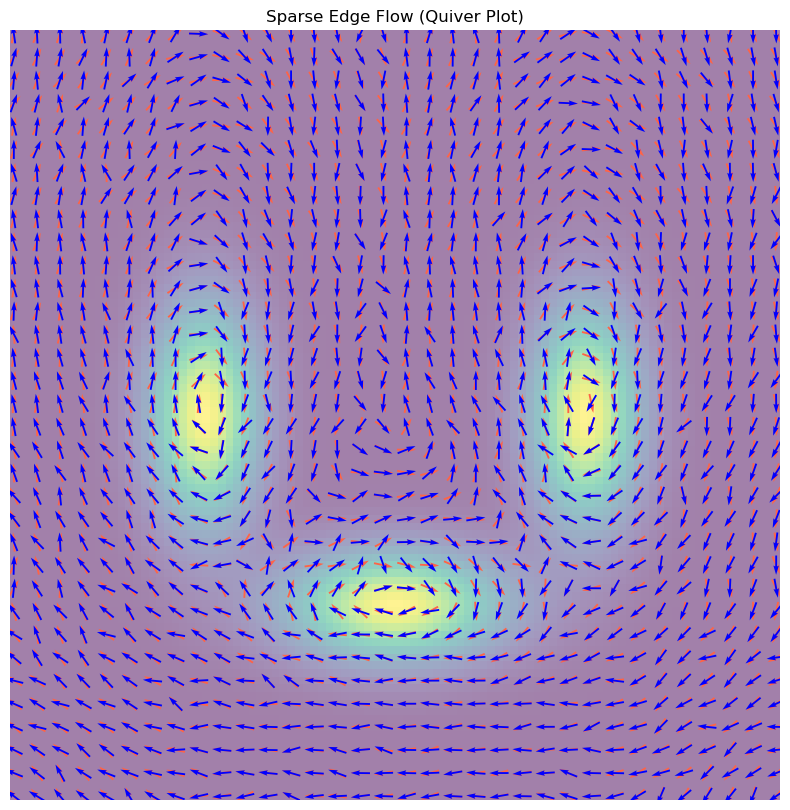

In [35]:
# ===== Add Noise========
noisy_angles = add_noise_a(sparse_angles,std=0.2)
noisy_dx,noisy_dy = angles_to_gradient(noisy_angles)


# plot_sparse_quiver(img_VG, noisy_grad_x_VG, noisy_grad_y_VG, step=30)

# Sparse Data
lie_group_manifold = so2(noisy_angles)

# Lie algebra so(2) manifold
lie_alg_manifold = to_lie_alg_manifold(lie_group_manifold)

new_lie_alg_manifold = forword_euler_mathod_lie_alg(lie_alg_manifold,70,dt=0.01)
new_thetas = lie_alg_manifold_to_orientations(new_lie_alg_manifold)

new_flow_x,new_flow_y = angles_to_gradient(new_thetas)
plot_two_sparse_quiver(img,noisy_dx, noisy_dy,new_flow_x,new_flow_y,step)